In [1]:
# Import necessary libraries
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from collections import deque

import torch
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.preprocessing import get_flattened_obs_dim
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib import RecurrentPPO

from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators

In [2]:
# ====================================
# Load Data
# ====================================

data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2015-01-01', '2023-01-01', '1d', ['RSI', 'EMA_50'])

data = data.copy()  # Make a full copy
data['Pct Change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)

# Define number of features (used in observation space)
num_features = 5

# ====================================
# Custom Environment Definition
# ====================================

class CryptoTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=1000, render_mode='human'):
        super(CryptoTradingEnv, self).__init__()
        
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.current_step = 1
        self.render_mode = render_mode
        
        self.actions_history = self.df[['Close', 'RSI']].copy()
        self.actions_history['Action'] = 0
        
        self.trade_fee = 0.001
        
        self._last_reward = 0
        self._last_action = 0
        self._balance_pct_buy = 0.1
        self._avg_buy_price = 0
        self._avg_sell_price = 0
        
        self.balance = initial_balance
        self.crypto_held = 0
        self.net_worth = initial_balance
        
        self.action_space = spaces.Discrete(3) # 0: Hold, 1: Buy, 2: Sell
        
        # Observation space: historical data + portfolio state
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)
    
        self._seed()
    
    def _seed(self, seed=None):
        np.random.seed(seed)
    
    def reset(self, seed = None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.crypto_held = 0
        self.net_worth = self.initial_balance
        
        self.actions_history = self.df[['Close', 'RSI']].copy()
        self.actions_history['Action'] = 0
        
        self._last_reward = 0
        self._last_action = 0
        self._balance_pct_buy = 0.1
        self._avg_buy_price = 0
        self._avg_sell_price = 0
        
        self.current_step = 1
        
        return self._get_observation(), {}
    
    def _get_price_features(self, index):
        return self.df.loc[index, ['Close', 'Volume', 'RSI', 'EMA_50', 'Pct Change']].values.astype(np.float32)
    
    def _get_observation(self):
        concatenated = np.concatenate([self._get_price_features(self.current_step), np.array([
            self.balance,
            self.crypto_held,
            self.net_worth, 
        ], dtype=np.float32)])

        return concatenated
    
    def _get_info(self):
        return dict(
            balance=self.balance,
            crypto_held=self.crypto_held,
            net_worth=self.net_worth,
            actions_history=self.actions_history,
        )
    
    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_observation(), 0, True, False, self._get_info()
        

        self._take_action(action)
        self.actions_history.loc[self.current_step, 'Action'] = action
        self.current_step += 1
  
        current_price = self.df.loc[self.current_step, 'Close']
        last_price = self.df.loc[self.current_step - 1, 'Close']
        
        # Calculate price change percentage
        price_change = (current_price - last_price) / last_price
        
        # Base reward on action and price movement
        reward = 0
        if action == 1:  # Buy
            reward = price_change * self.crypto_held * current_price
        elif action == 2:  # Sell
            reward = -price_change * self.crypto_held * current_price
        
        self._last_reward = reward
        self._last_action = action
    
  
        done = False
        
        if self.net_worth <= self.initial_balance * 0.5:
            done = True
        
        return self._get_observation(), reward, done, False, self._get_info()
    
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, 'Close']
        last_price = self.df.loc[self.current_step - 1, 'Close']
        
        if action == 1:  # Buy
            balance_to_buy = self.balance * 1
            crypto_can_buy = balance_to_buy / current_price
            self._avg_buy_price = (self._avg_buy_price + current_price) / 2

            self.crypto_held += crypto_can_buy
            self.balance -= crypto_can_buy * current_price
        
        elif action == 2:  # Sell
            amount_to_sell = self.crypto_held * 1
            self._avg_sell_price = (self._avg_sell_price + current_price) / 2
                
            self.balance += (amount_to_sell * current_price)
            self.crypto_held = self.crypto_held - amount_to_sell
        
        self.net_worth = self.balance + self.crypto_held * current_price
    
    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}, Balance: {self.balance}, Crypto Held: {self.crypto_held}, Last Reward: {self._last_reward}, Last Action: {self._last_action}, Avg Buy Price: {self._avg_buy_price}, Avg Sell Price: {self._avg_sell_price}')
        
# ====================================
# Environment Setup and Model Training
# ====================================

print(data.shape)
env = DummyVecEnv([lambda: CryptoTradingEnv(data)])
env = VecNormalize(env, norm_obs=True, norm_reward=True)
env = VecMonitor(env)

check_env(env.envs[0])

# policy_kwargs = dict(
#     features_extractor_class=CustomCombinedExtractor,
#     features_extractor_kwargs=dict(features_dim=128),
# )

eval_callback = EvalCallback(env, best_model_save_path='./models/',
                             log_path='./tensorboard_logs/', eval_freq=1000,
                             deterministic=True, render=False, verbose=1)

[*********************100%***********************]  1 of 1 completed

(2872, 9)


In [5]:
policy_kwargs = dict(
    normalize_images=False,
) 
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log="./tensorboard_logs/", learning_rate=0.0002, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=100_000, callback=eval_callback, log_interval=1000)


Using cuda device
Logging to ./tensorboard_logs/RecurrentPPO_5


KeyboardInterrupt: 

[*********************100%***********************]  1 of 1 completed


Step: 2, Net Worth: 1000.0, Balance: 0.0, Crypto Held: 0.016739046696905492, Last Reward: -2.5842429056779013, Last Action: 1, Avg Buy Price: 29870.279296875, Avg Sell Price: 0
Step: 3, Net Worth: 997.4090440415434, Balance: 0.0, Crypto Held: 0.016739046696905492, Last Reward: -1.0295633820644783, Last Action: 1, Avg Buy Price: 44728.0263671875, Avg Sell Price: 0
Step: 4, Net Worth: 996.3784157054628, Balance: 0.0, Crypto Held: 0.016739046696905492, Last Reward: -4.162452619746476, Last Action: 1, Avg Buy Price: 52126.11474609375, Avg Sell Price: 0
Step: 5, Net Worth: 992.1984272750211, Balance: 0.0, Crypto Held: 0.016739046696905492, Last Reward: -1.59574270664985, Last Action: 1, Avg Buy Price: 55700.301513671875, Avg Sell Price: 0
Step: 6, Net Worth: 990.6001098630712, Balance: 0.0, Crypto Held: 0.016739046696905492, Last Reward: 1.0974244802128683, Last Action: 1, Avg Buy Price: 57439.65270996094, Avg Sell Price: 0
Step: 7, Net Worth: 991.6963212610151, Balance: 0.0, Crypto Held: 0

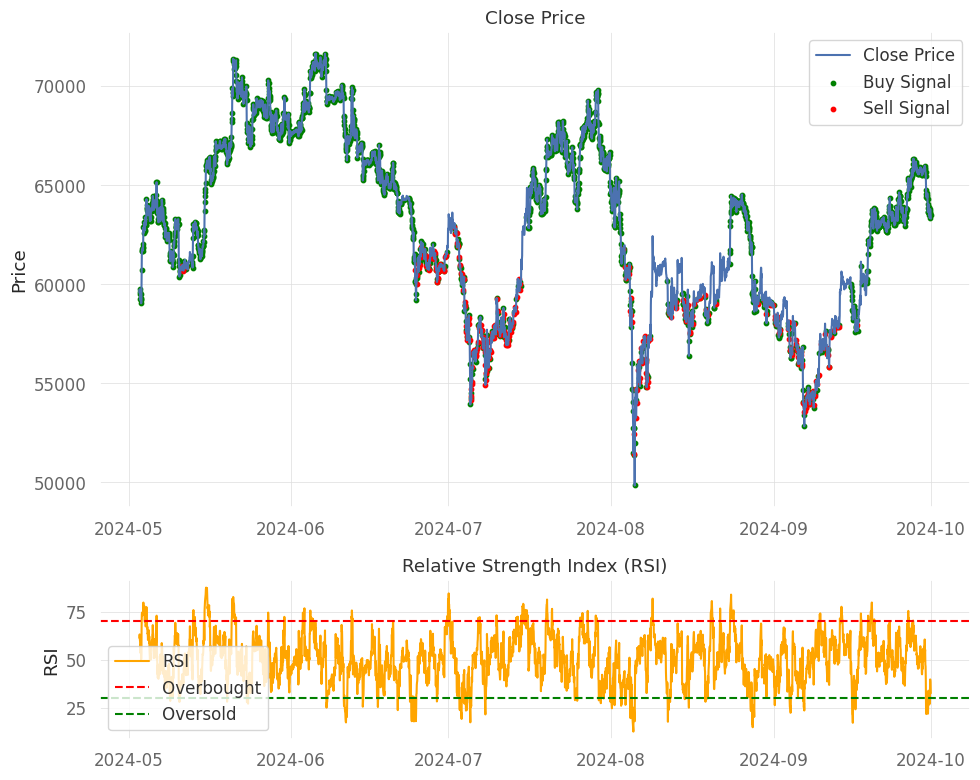

                    Strategy
------------------  ----------
Start Period        2024-05-03
End Period          2034-04-01
Risk-Free Rate      0.0%
Time in Market      89.0%

Cumulative Return   5.18%
CAGR﹪              0.35%

Sharpe              0.08
Prob. Sharpe Ratio  62.53%
Sortino             0.12
Sortino/√2          0.09
Omega               1.02

Max Drawdown        -31.88%
Longest DD Days     2814

Gain/Pain Ratio     0.02
Gain/Pain (1M)      0.09

Payoff Ratio        1.03
Profit Factor       1.02
Common Sense Ratio  1.02
CPC Index           0.52
Tail Ratio          1.01
Outlier Win Ratio   5.43
Outlier Loss Ratio  4.48

MTD                 0.0%
3M                  -2.81%
6M                  -0.02%
YTD                 -2.81%
1Y                  5.67%
3Y (ann.)           2.24%
5Y (ann.)           0.89%
10Y (ann.)          0.35%
All-time (ann.)     0.35%

Avg. Drawdown       -2.69%
Avg. Drawdown Days  163
Recovery Factor     0.29
Ulcer Index         0.15
Serenity Index      0.01


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


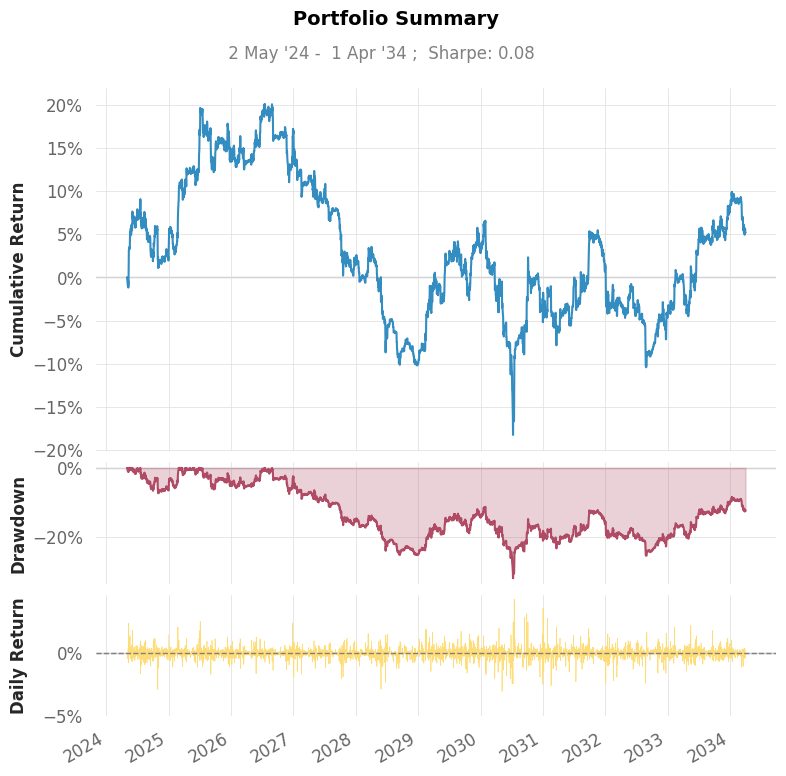

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


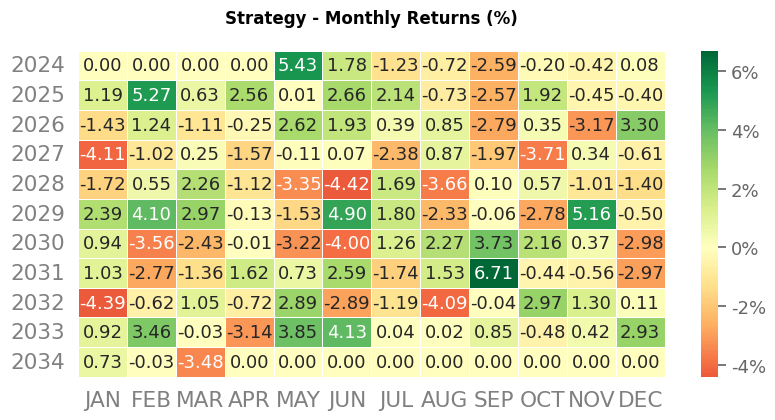

In [6]:
import quantstats as qs

from utils.charts.plot_data_with_rsi import plot_data_with_rsi

# ====================================
# Model Evaluation (Optional)
# ====================================

test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-10-01', '1d', ['RSI', 'EMA_50'])

test_data = test_data.copy()  # Make a full copy
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)

eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

portfolio_values = []

model = RecurrentPPO.load('./models/best_model')

obs = eval_env.reset()
done = False
state = None
episode_starts = np.ones((1,), dtype=bool)
while not done:
    action, state = model.predict(obs, state=state, deterministic=True, episode_start=episode_starts)
    obs, reward, done, info = eval_env.step(action)
    
    portfolio_values.append(info[0]['net_worth'])   
    
    eval_env.render()
    
    episode_starts = done
    
    if done:
        actions_history = info[0]['actions_history']
        print('Episode done!')
    
eval_env.close()

# ====================================
# Portfolio Analysis
# ====================================

actions_history.index = pd.to_datetime(test_data.index)

plot_data_with_rsi(actions_history)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)

